# Deep Learning Portfolio Project
In this notebook I want to present you a deep learning portfolio project. I want to develop a car classifier, which takes a car as input and returns the manufacturer, in case the manufacturer is known. 

## Dataset
The open source car dataset from Standford is used in this notebook (source: https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

## Steps
1. Check data distribution.
2. Create tensorflow input pipeline with normalization.
3. Use small images to find best suited cnn.
4. Apply data augmentation.
5. Check different images sizes on winning cnn.
6. Check oversampling vs. imblanced. 
7. Apply Bayesian Hyperparameter Search to find best hyperparameters.
8. Train final model.
9. Plot Class Activation Maps.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

## Data Import

In [2]:
import scipy.io as sio
matfile = sio.loadmat(r"data\cars_annos.mat")

In [3]:
# get the keys of this dictionary
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [4]:
matfile['annotations'][0]

array([(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       ...,
       (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
       (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([[60]],

In [5]:
data = [[row.flat[0] for row in line] for line in matfile['annotations'][0]]

columns = ["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "test"]

df = pd.DataFrame(data, columns=columns)

In [6]:
df.head()

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [7]:
# drop the bounding box information, because we are only applying normal image classification
df = df.drop(columns=["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"])

In [8]:
df.head()

,filename,class,test
0,car_ims/000001.jpg,1,0
1,car_ims/000002.jpg,1,0
2,car_ims/000003.jpg,1,0
3,car_ims/000004.jpg,1,0
4,car_ims/000005.jpg,1,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  16185 non-null  object
 1   class     16185 non-null  int8  
 2   test      16185 non-null  int8  
dtypes: int8(2), object(1)
memory usage: 158.2+ KB


In [10]:
df["class"] = df["class"].astype(np.uint8)
df["test"] = df["test"].astype(np.uint8)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  16185 non-null  object
 1   class     16185 non-null  uint8 
 2   test      16185 non-null  uint8 
dtypes: object(1), uint8(2)
memory usage: 158.2+ KB


In [12]:
# remove the folder car_ims from the filenames to only have the filename
df["filename"] = df["filename"].apply(lambda x: x.replace("car_ims/", ""))
df.head()

,filename,class,test
0,000001.jpg,1,0
1,000002.jpg,1,0
2,000003.jpg,1,0
3,000004.jpg,1,0
4,000005.jpg,1,0


In [13]:
# get some statistics
df.describe()

,class,test
count,16185.000000,16185.000000
mean,98.977448,0.496818
std,56.502610,0.500005
min,1.000000,0.000000
25%,50.000000,0.000000
50%,99.000000,0.000000
75%,148.000000,1.000000
max,196.000000,1.000000


In [14]:
# check unique values and get number of classes
for column in df.columns:
    print(f"Column {column} contains {df[column].unique().shape[0]} unique values. { 100 * df[column].unique().shape[0] / df[column].shape[0]}% of total data. \n")

Column filename contains 16185 unique values. 100.0% of total data. 

Column class contains 196 unique values. 1.2109978375038617% of total data. 

Column test contains 2 unique values. 0.01235712079085573% of total data. 



There are in total 196 different classes available. Let's now check how many of the images are used for testing.

In [15]:
num_images = df.shape[0]
num_test = np.sum(df["test"] == 1)
print(f"There are {num_images} images in this dataset.")
print(f"{num_test} of these images are in the test set ({100 * num_test / num_images}% of total data).")

There are 16185 images in this dataset.
8041 of these images are in the test set (49.68180413963547% of total data).


In [16]:
# get the class names
class_names = [[row.flat[0] for row in line] for line in matfile['class_names'][0]]

In [17]:
class_names = [class_names[idx][0] for idx in range(len(class_names))]

In [18]:
class_names

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

There are a lot of different classes but we only have few images. Let's reduce the training effort and the amount of classes to train on by only predicting which manufacturer produced the car and not also which exact model we have here!

In [19]:
list_long_manufacturer = ["Aston Martin", "Land Rover"]
new_class_names = list(set( [full_name.split(" ")[0] if not any([manu in full_name for manu in list_long_manufacturer])
                                                     else " ".join(full_name.split(" ")[:2])
                                                     for full_name in class_names] ))

In [20]:
new_class_names

['Nissan',
 'Ram',
 'Mercedes-Benz',
 'Mazda',
 'Suzuki',
 'Chrysler',
 'FIAT',
 'Infiniti',
 'Acura',
 'Buick',
 'AM',
 'Fisker',
 'Toyota',
 'Land Rover',
 'Volvo',
 'Scion',
 'smart',
 'HUMMER',
 'Volkswagen',
 'Audi',
 'Aston Martin',
 'Eagle',
 'Ford',
 'Lincoln',
 'MINI',
 'Dodge',
 'Geo',
 'Ferrari',
 'Plymouth',
 'Porsche',
 'Chevrolet',
 'Maybach',
 'Jeep',
 'Jaguar',
 'Honda',
 'Lamborghini',
 'Rolls-Royce',
 'Bentley',
 'Spyker',
 'Tesla',
 'Daewoo',
 'Hyundai',
 'McLaren',
 'Isuzu',
 'Mitsubishi',
 'Cadillac',
 'GMC',
 'Bugatti',
 'BMW']

In [21]:
# get new number of classes
print(f"New number of classes: {len(new_class_names)}")

New number of classes: 49


Nice! Now we only have 49 classes left. But before we continue, we first have to map the old class integers to the new ones in order to not flip everything! Let's do this first. <br> 
Let's use the index of the new classes list and map each old class with manufacturer and model name to the new index where we only have the manufacturer left. For this, dictionaries are a nice choice!

In [22]:
dict_old_class_to_new_class = {}
new_indices = np.arange(len(new_class_names))
for old_class in class_names:
    new_index = new_indices[[new_class in old_class for new_class in new_class_names]]
    dict_old_class_to_new_class[old_class] = new_index[0]

In [23]:
dict_old_class_to_new_class

{'AM General Hummer SUV 2000': 10,
 'Acura RL Sedan 2012': 8,
 'Acura TL Sedan 2012': 8,
 'Acura TL Type-S 2008': 8,
 'Acura TSX Sedan 2012': 8,
 'Acura Integra Type R 2001': 8,
 'Acura ZDX Hatchback 2012': 8,
 'Aston Martin V8 Vantage Convertible 2012': 20,
 'Aston Martin V8 Vantage Coupe 2012': 20,
 'Aston Martin Virage Convertible 2012': 20,
 'Aston Martin Virage Coupe 2012': 20,
 'Audi RS 4 Convertible 2008': 19,
 'Audi A5 Coupe 2012': 19,
 'Audi TTS Coupe 2012': 19,
 'Audi R8 Coupe 2012': 19,
 'Audi V8 Sedan 1994': 19,
 'Audi 100 Sedan 1994': 19,
 'Audi 100 Wagon 1994': 19,
 'Audi TT Hatchback 2011': 19,
 'Audi S6 Sedan 2011': 19,
 'Audi S5 Convertible 2012': 19,
 'Audi S5 Coupe 2012': 19,
 'Audi S4 Sedan 2012': 19,
 'Audi S4 Sedan 2007': 19,
 'Audi TT RS Coupe 2012': 19,
 'BMW ActiveHybrid 5 Sedan 2012': 48,
 'BMW 1 Series Convertible 2012': 48,
 'BMW 1 Series Coupe 2012': 48,
 'BMW 3 Series Sedan 2012': 48,
 'BMW 3 Series Wagon 2012': 48,
 'BMW 6 Series Convertible 2007': 48,
 '

In [24]:
# lets now adapt the dataframe to match the new classes
df["new_class"] = df["class"].apply(lambda x: dict_old_class_to_new_class[class_names[x-1]])

In [25]:
df.head()

,filename,class,test,new_class
0,000001.jpg,1,0,10
1,000002.jpg,1,0,10
2,000003.jpg,1,0,10
3,000004.jpg,1,0,10
4,000005.jpg,1,0,10


In [26]:
df["class"].value_counts()

119    136
79      97
161     96
167     95
144     93
      ... 
175     61
64      59
158     58
99      55
136     48
Name: class, Length: 196, dtype: int64

## EDA

Let's first check the shape of the images. For this, let's load some images into numpy arrays and check the shapes. For this, I only want to check the shapes of the first images in order to check whether they are of equal size or not. If not, then different images sizes are to be tested for the final model and the best performing shall be used in the end.

In [27]:
from PIL import Image

def files_to_numpy(df, folder):
    list_of_files = df["filename"][:20].to_list()
    
    # read data into numpy array
    for img_file in list_of_files:
        image = np.array(Image.open(os.path.join(folder, img_file) ))
        print(image.shape)

In [28]:
files_to_numpy(df, r"data\car_ims")

(768, 1024, 3)
(219, 460, 3)
(233, 310, 3)
(188, 250, 3)
(64, 85, 3)
(111, 250, 3)
(176, 464, 3)
(85, 113, 3)
(276, 300, 3)
(111, 148, 3)
(72, 96, 3)
(100, 160, 3)
(179, 300, 3)
(120, 160, 3)
(71, 94, 3)
(93, 124, 3)
(91, 160, 3)
(525, 700, 3)
(272, 450, 3)
(439, 700, 3)


Okay. Seems like there are a lot of different images sizes available. Let's later check different images sizes and train models on them in order to find the best suited. In addition, let's convert the images into grayscale images later, because this should be sufficient for a cars classifier. <br> <br>
Let's now take a look into some images.

In [29]:
def show_image(df, folder, index, classes=new_class_names):
    filename = os.path.join(folder, df["filename"][index])
    class_name = classes[df["new_class"][index]]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.imshow(image)

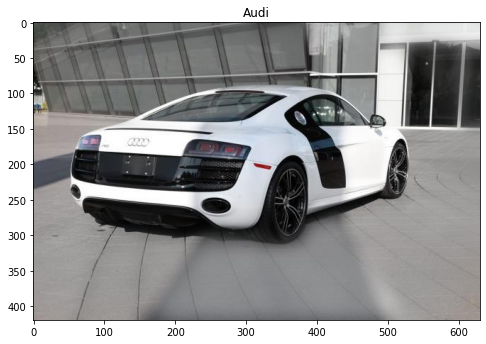

In [30]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

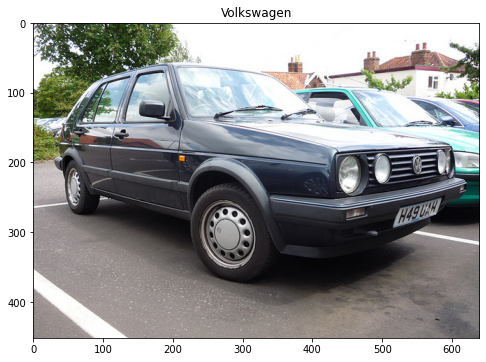

In [31]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

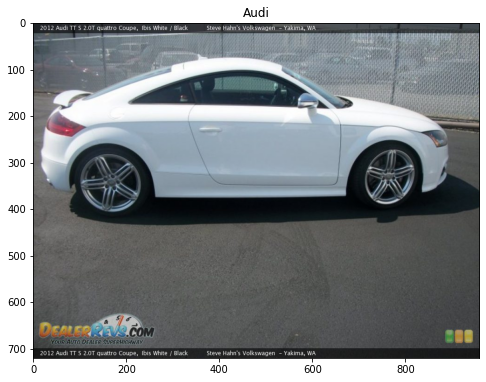

In [32]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

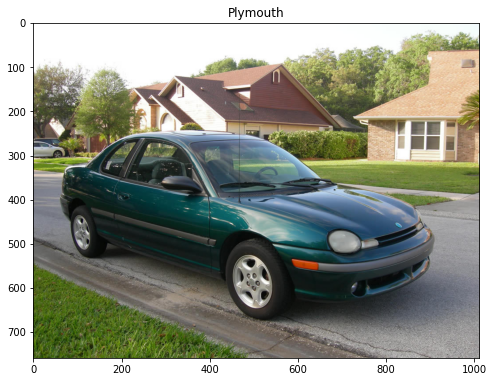

In [33]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

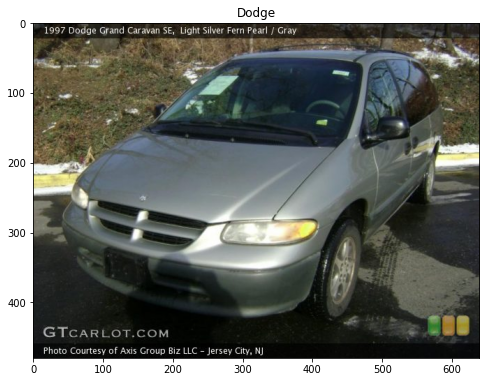

In [34]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

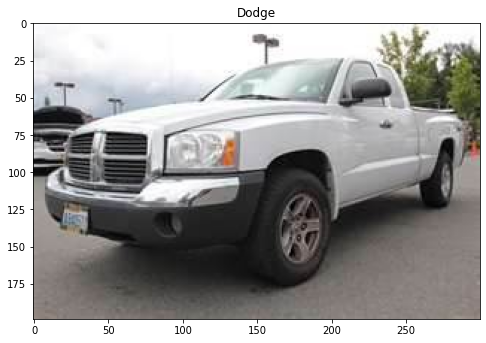

In [35]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

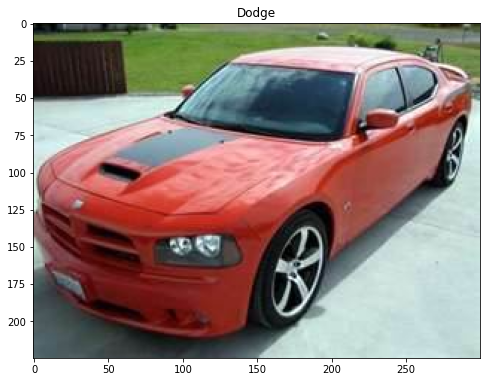

In [36]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

### Check distribution of data
Let's now check the data distribution. This is to check if there are enough images for each class and to maybe apply some data imbalance strategies for balancing the dataset.

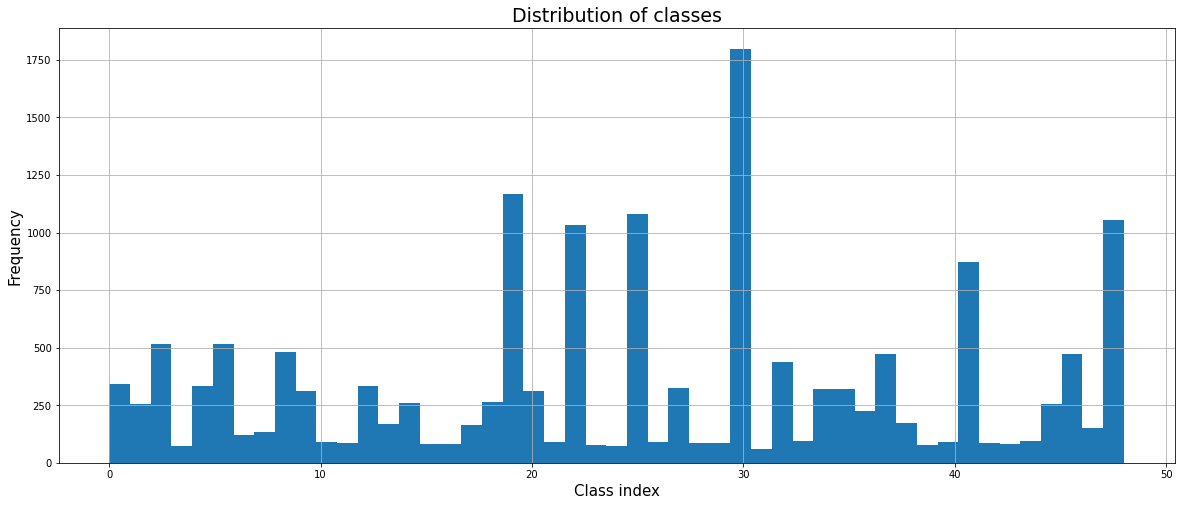

In [37]:
plt.figure(figsize=(20, 8))
df["new_class"].hist(bins=len(new_class_names))
plt.title("Distribution of classes", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

The dataset looks quite balanced. However, some classes seem to have less samples than others, which could result in a worse performance of the model on these classes. Let's later check if balancing can improve the overal performance! <br> <br>
Let's now check the distributions for the training and test set. This is important to ensure that the test set contains a similar distribution than the training set. For this dataset, almost the half of all images are in the test set. I think this is done in order to ensure that there are enough images of all classes in the test set. 

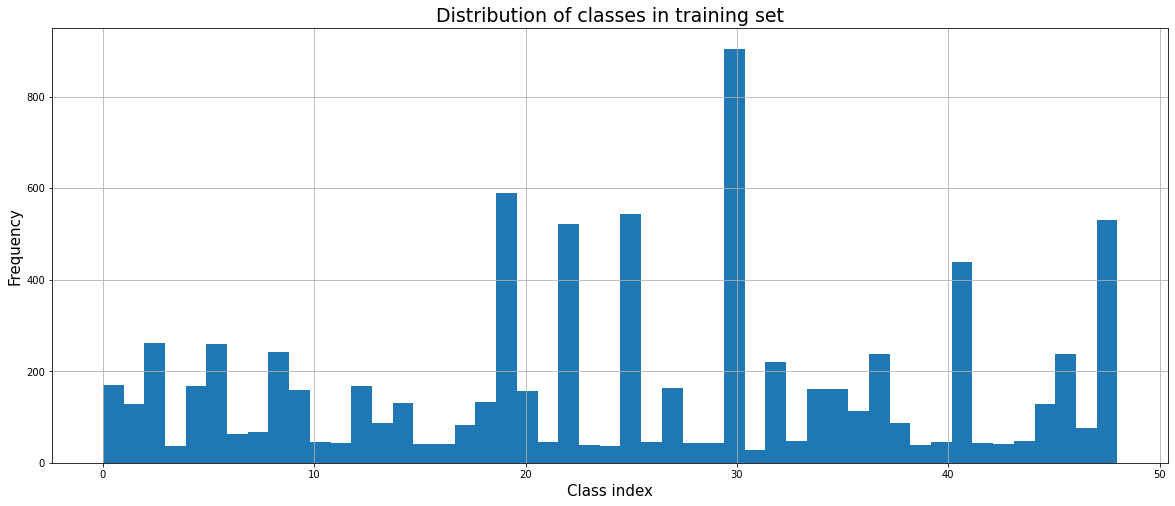

In [38]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 0]["new_class"].hist(bins=len(new_class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

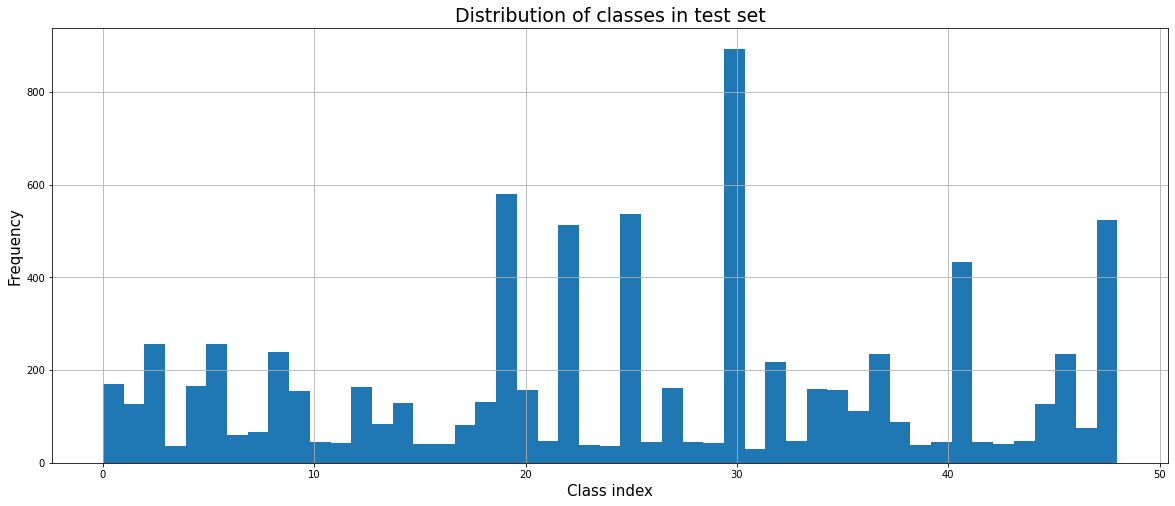

In [39]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 1]["new_class"].hist(bins=len(new_class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

As one can see, the distributions are almost the same! This is perfect, because the test set therefore represents the real distribution and we can better test the performance of the final model! <br> <br>
Let's now create a training and a validation set and let's check the distributions there. But before splitting, we should one-hot encode the labels!

In [40]:
# start with one-hot encoding the column "class"
df_encoded = pd.get_dummies(df, columns=["new_class"])
df_encoded.columns = ["filename", "class", "test", *new_class_names]
df_encoded.head()

,filename,class,test,Nissan,Ram,Mercedes-Benz,Mazda,Suzuki,Chrysler,FIAT,...,Tesla,Daewoo,Hyundai,McLaren,Isuzu,Mitsubishi,Cadillac,GMC,Bugatti,BMW
0,000001.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000002.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000003.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000004.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000005.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

df_training = df_encoded.loc[df["test"] == 0]
df_test = df_encoded.loc[df["test"] == 1]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df_training.drop(columns=new_class_names), df_training[new_class_names]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_training.iloc[train_index]
    df_val = df_training.iloc[test_index]

TRAIN: [2436 3685  135 ... 4686   33 2414] TEST: [  22 2521 2906 ... 3274 1850 1492]


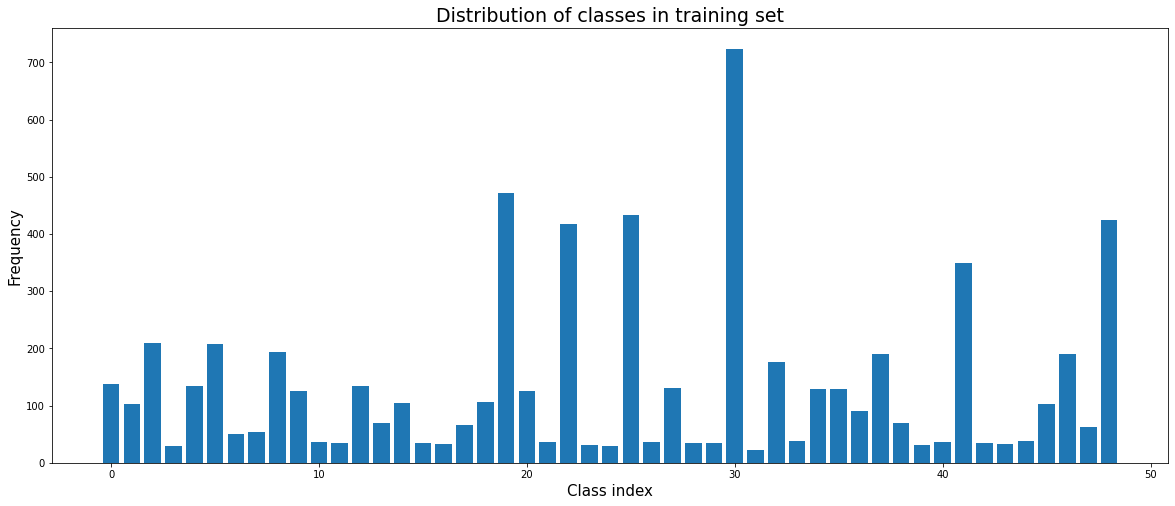

In [42]:
plt.figure(figsize=(20, 8))
count_classes_train = df_train[new_class_names].sum(axis=0).values
bins = np.arange(0, len(new_class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

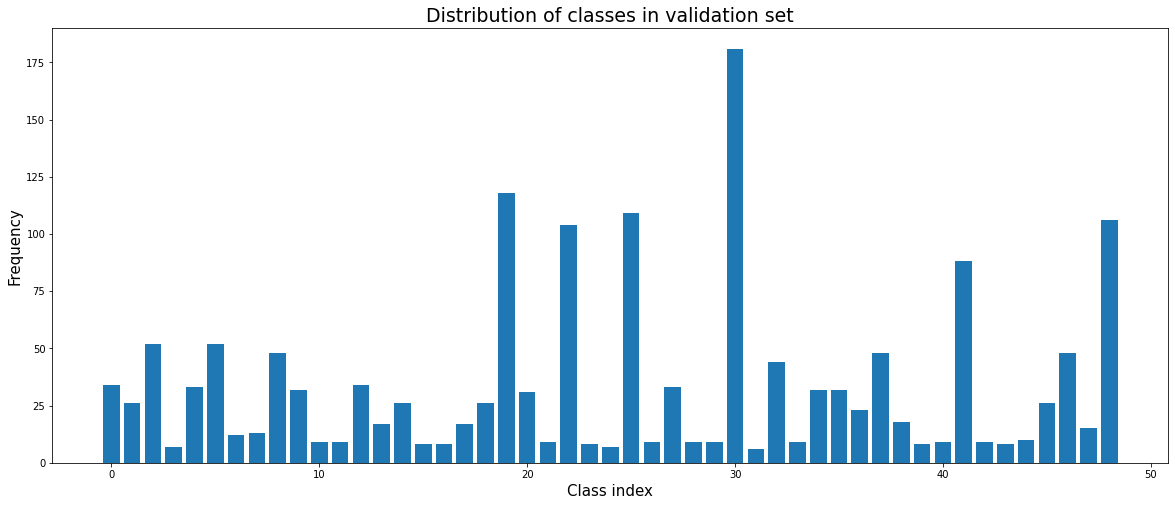

In [43]:
# check distribution of test set
plt.figure(figsize=(20, 8))
count_classes_test = df_val[new_class_names].sum(axis=0).values
bins = np.arange(0, len(new_class_names))
plt.bar(x=bins, height=count_classes_test)
plt.title("Distribution of classes in validation set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

## Create Tensorflow Input Pipeline

In [44]:
import imgaug.augmenters as iaa

def apply_augmentations(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0)
               ]
    for idx, aug in enumerate(aug_list):
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        random_nr = np.random.rand()
        input_image = np.clip(aug(images=input_image), 0., 255.) if random_nr <= 0.8 else input_image
    
    return np.squeeze(input_image, axis=0)

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_augmentations)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

In [46]:
# create datagenerators by calling flow_from_dataframe on them
path_to_images = r"data\car_ims"
batch_size = 8
shuffle = True
target_size = (32, 32)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filename", y_col=df_train.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

Found 6515 validated image filenames.
Found 1629 validated image filenames.


Now: Check the format in order to ensure that the images are valid when they are entered into the CNN.

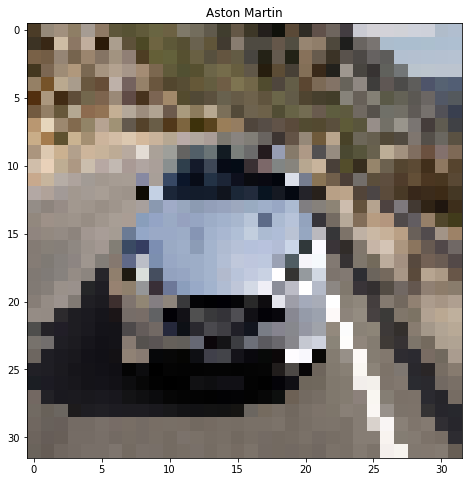

In [47]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(new_class_names[np.argmax(label)])
plt.imshow(image)

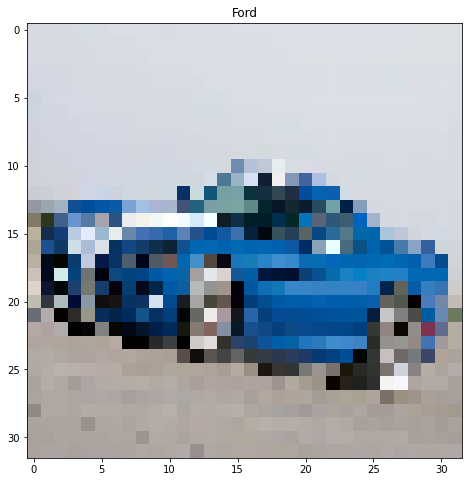

In [48]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(new_class_names[np.argmax(label)])
plt.imshow(image)

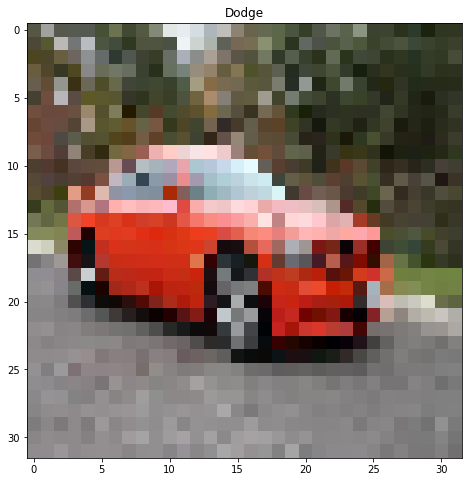

In [49]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(new_class_names[np.argmax(label)])
plt.imshow(image)

Let's now build a keras model factory to try out different cnns and use the best performing by considering the trade off between performance and complexity.

In [50]:
class KerasModelFactory():
    '''
    This class can be used to create a keras model and return it.
    '''
    
    def __init__(self):
        '''
        Constructor...
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str) or 
           model_name not in ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]):
                raise ValueError("Input model_name is invalid! Check if it is of type string and if its in the list of models.")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "efficientnetb0":
            from tensorflow.keras.applications import EfficientNetB0
            model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "xception":
            from tensorflow.keras.applications import Xception
            model = Xception(weights=weights, include_top=False, input_shape=input_shape)
        else:
            from classification_models.tfkeras import Classifiers
            net, _ = Classifiers.get(model_name)
            model = net(input_shape=input_shape, weights=weights, include_top=False)
            
        # add a global spatial average pooling layer
        # this helps to decrease the risk of overfitting and to plot class activation maps
        x = model.output
        x = keras.layers.GlobalAveragePooling2D()(x)

        # and a fully connected output/classification layer
        predictions = keras.layers.Dense(num_classes, activation=activation_func)(x)

        # create the full network so we can train on it
        model = keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [51]:
# test keras factory
factory = KerasModelFactory()

model = factory.create_and_return_keras_model("densenet121", 
                                              num_classes=len(new_class_names), 
                                              input_shape=(32, 32, 3),
                                              activation_func="softmax",
                                              transfer_learning=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block12_1_bn (BatchNormal (None, 1, 1, 128)    512         conv5_block12_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block12_1_relu (Activatio (None, 1, 1, 128)    0           conv5_block12_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block12_2_conv (Conv2D)   (None, 1, 1, 32)     36864       conv5_block12_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block12_concat (Concatena (None, 1, 1, 896)    0           conv5_block11_concat[0][0]       
                                                                 conv5_block12_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block13_0_bn (BatchNormal (None, 1, 1, 896)    3584        conv5_block12_concat[0][0]       
__________

Let's now train the DenseNet121 for a small amount of epochs in order to check whether the task is learnable or not.

In [59]:
initial_learning_rate = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# define the metrics
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(),
    keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

In [60]:
# train for 5 epochs
hist_dict = model.fit(train_generator, epochs=5, verbose=1, validation_data=valid_generator)

Epoch 1/5
 77/815 [=>............................] - ETA: 3:12 - loss: 4.2853 - categorical_accuracy: 0.0763 - auc: 0.6815 - f1_score: 0.0190

KeyboardInterrupt: 

Let's now compare different cnn encoders and choose the best one by considering the number of trainable parameters and the performance on the validation set. <br>
A cross-validation would be good for choosing the models. However, I decided to not use a cross validation in order to speed up the training process a little bit. <br> <br>
Steps for training the different encoders:
1. Train encoder for 20 epochs and store best validation f1-score of the encoder.
2. Create a plot with trainable parameters on x-axis and best score on y-axis. 
3. Use plot to decide which cnn architecture to use.

In [61]:
encoder_list = ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
num_epochs = 1
results_dict = dict()

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(new_class_names), 
                                              input_shape=(128, 128, 3),
                                              activation_func="softmax",
                                              transfer_learning=True)
    
    initial_learning_rate = 1e-3
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = [np.max(hist_dict.history["val_f1_score"]), np.max(hist_dict.history["val_categorical_accuracy"])]

Start training efficientnetb0...
815/815 [==============================] - 182s 208ms/step - loss: 3.9427 - categorical_accuracy: 0.0669 - auc: 0.6720 - f1_score: 0.0038 - val_loss: 3.8089 - val_categorical_accuracy: 0.1087 - val_auc: 0.7054 - val_f1_score: 0.0034
Start training xception...
815/815 [==============================] - 481s 582ms/step - loss: 3.6405 - categorical_accuracy: 0.0993 - auc: 0.7210 - f1_score: 0.0000e+00 - val_loss: 5.2831 - val_categorical_accuracy: 0.1068 - val_auc: 0.7096 - val_f1_score: 0.0050
Start training densenet121...
467/815 [================>.............] - ETA: 1:31 - loss: 3.9511 - categorical_accuracy: 0.0866 - auc: 0.7055 - f1_score: 0.0054

KeyboardInterrupt: 

Now we have a well suited cnn architecture. Let's now check which augmentations we can use such that the overal performance is improved in comparison to the baseline performance. In order to check this, a cnn is trained using one additional augmentation at a time and it's checked whether the best validation f1-score improved in comparison to the baseline model, which is only trained with a left-right flip.

In [54]:
def apply_baseline_plus_one_augmentation(augmentation):
    def apply_augmentation(input_image):
        input_image = np.expand_dims(input_image, axis=0)
        aug_list = [
                    iaa.Fliplr(1.0)
                   ]
        if augmentation == "add":
            aug_list.append(iaa.Add((-60, 60)))
        elif augmentation == "gaussian_noise":
            aug_list.append(iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)))
        elif augmentation == "multiply":
            aug_list.append(iaa.Multiply((0.5, 1.5)))
        elif augmentation == "salt_and_pepper":
            aug_list.append(iaa.SaltAndPepper(0.1))
        elif augmentation == "motion_blur":
            aug_list.append(iaa.MotionBlur(k=15))
        elif augmentation == "gamma_contrast":
            aug_list.append(iaa.GammaContrast((0.5, 2.0)))
        elif augmentation == "scaling":
            aug_list.append(iaa.Affine(scale=(0.5, 1.2)))
        elif augmentation == "rotate":
            aug_list.append(iaa.Rotate((-45, 45)))
        elif augmentation == "elastic_transformation":
            aug_list.append(iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0))
        for idx, aug in enumerate(aug_list):
            # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
            # augment, such that ~ 20 % of the images are not augmented
            random_nr = np.random.rand()
            input_image = np.clip(aug(images=input_image), 0., 255.) if random_nr <= 0.55 else input_image

        return np.squeeze(input_image, axis=0)
    return apply_augmentation

In [56]:
augmentations_list = [
                        "add", "gaussian_noise", "mutliply", "salt_and_pepper", "motion_blur", 
                        "gamma_contrast", "scaling", "rotate", "elastic_transformation"                 
                     ]
num_epochs = 1
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
shuffle = True
target_size = (32, 32)
aug_results_dict = dict()

for aug in augmentations_list:
    print(f"Start training with augmentation {aug}...")
    
    # setup input pipeline
    datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_baseline_plus_one_augmentation(aug))
    datagen_val = ImageDataGenerator(rescale = 1. / 255)
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                        x_col="filename", y_col=df_train.columns[3:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)

    valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                        x_col="filename", y_col=df_val.columns[3:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)

    steps_per_epoch_train = train_generator.__len__()
    steps_per_epoch_val = valid_generator.__len__()
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(new_class_names), 
                                                  input_shape=(32, 32, 3),
                                                  activation_func="softmax",
                                                  transfer_learning=True)
    
    initial_learning_rate = 1e-3
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    aug_results_dict[aug] = [np.max(hist_dict.history["val_f1_score"]), np.max(hist_dict.history["val_categorical_accuracy"])]

Start training with augmentation add...
Found 6515 validated image filenames.
Found 1629 validated image filenames.
815/815 [==============================] - 251s 290ms/step - loss: 3.9891 - categorical_accuracy: 0.0843 - auc: 0.6968 - f1_score: 0.0035 - val_loss: 11.5984 - val_categorical_accuracy: 0.0528 - val_auc: 0.6341 - val_f1_score: 0.0128
Start training with augmentation gaussian_noise...
Found 6515 validated image filenames.
Found 1629 validated image filenames.
815/815 [==============================] - 227s 261ms/step - loss: 3.9646 - categorical_accuracy: 0.0843 - auc: 0.6995 - f1_score: 0.0020 - val_loss: 11.6540 - val_categorical_accuracy: 0.0816 - val_auc: 0.6626 - val_f1_score: 0.0209
Start training with augmentation mutliply...
Found 6515 validated image filenames.
Found 1629 validated image filenames.
815/815 [==============================] - 241s 279ms/step - loss: 3.9621 - categorical_accuracy: 0.0856 - auc: 0.7020 - f1_score: 0.0041 - val_loss: 3.7054 - val_categ

In [61]:
pd.DataFrame.from_dict(aug_results_dict, orient="index", columns=["val_f1_score", "val_categorical_accuracy"])

,val_f1_score,val_categorical_accuracy
add,0.012756,0.052793
gaussian_noise,0.020869,0.081645
mutliply,0.000000,0.107428
salt_and_pepper,0.008403,0.066912
motion_blur,0.012557,0.079804
gamma_contrast,0.000760,0.074279
scaling,0.000000,0.111111
rotate,0.005618,0.100061
elastic_transformation,0.004474,0.074279


Let's create the final augmentation function which only contains the augmentations that led to an improvement over the baseline model. In addition, augmentations shall only be applied such that approximately 20% of the images are not augmented.

In [56]:
def apply_augmentation(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0),
                iaa.Multiply((0.5, 1.5)),
                iaa.SaltAndPepper(0.1),
                [iaa.GammaContrast((0.8, 1.2)),iaa.Add((-60, 60))],
                iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                iaa.MotionBlur(k=15),
                iaa.Affine(scale=(0.5, 1.2)),
                iaa.Rotate((-45, 45)),
                iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0),
              ]                
    for idx, aug in enumerate(aug_list):
        # only apply augmentation such that in total 10% of the images are not augmented
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        rand_nr = np.random.rand()
        threshold = 0.21
        if isinstance(aug, list):
            rand_aug = np.random.randint(0, 2)
            input_image = np.clip(aug[rand_aug](images=input_image), 0., 255.) if rand_nr <= threshold else input_image
        else:
            input_image = np.clip(aug(images=input_image), 0., 255.) if rand_nr <= threshold else input_image

    return np.squeeze(input_image, axis=0)

As a next step, the network shall be trained with different image sizes in order to find the best image size. 

In [64]:
list_image_sizes = [(32, 32), (64, 64), (128, 128), (256, 256)]
num_epochs = 1
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
depth = 3 # using rgb
shuffle = True
img_size_results_dict = dict()

for target_size in list_image_sizes:
    print(f"Start training with target size of {target_size}...")
    img_height, img_width = target_size
    
    # setup input pipeline
    datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
    datagen_val = ImageDataGenerator(rescale = 1. / 255)
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                        x_col="filename", y_col=df_train.columns[3:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)

    valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                        x_col="filename", y_col=df_val.columns[3:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(new_class_names), 
                                                  input_shape=(img_height, img_width, depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)
    
    initial_learning_rate = 1e-3
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    img_size_results_dict[target_size] = [np.max(hist_dict.history["val_f1_score"]), 
                                          np.max(hist_dict.history["val_categorical_accuracy"])]

Start training with target size of (32, 32)...
Found 6515 validated image filenames.
Found 1629 validated image filenames.
815/815 [==============================] - 256s 296ms/step - loss: 4.0217 - categorical_accuracy: 0.0823 - auc: 0.6872 - f1_score: 0.0046 - val_loss: 4.6965 - val_categorical_accuracy: 0.0203 - val_auc: 0.6596 - val_f1_score: 0.0043


NameError: name 'aug' is not defined

In [ ]:
pd.DataFrame.from_dict(img_size_results_dict, orient="index", columns=["val_f1_score", "val_categorical_accuracy"])

Perfect. Now we also have our optimal image size. Let's now continue and check whether we should apply some oversampling to balance the dataset or not. <br> <br>
Important: Oversampling should only be applied on the training set and not on the overal dataset! This is to ensure that no images of the training set are also in the validation or even worse in the test set!

In [53]:
def oversample_dataframe(df):
    # create copy of dataframe
    df_copy = df.copy()
    
    # find majortiy class count
    count_majority = df_copy[df_copy.columns[3:]].sum().max()
    
    # loop over all classes and oversample until count_majority number of samples are reached
    balanced_columns_list = list()
    for col in df_copy.columns[3:]:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_1 = df_copy[df_copy[col] == 1]
        # get the number of samples within that class
        count_class_1 = df_class_1.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_oversampled = df_class_1.sample(count_majority - count_class_1, replace=True)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(pd.concat([df_class_1, df_oversampled]))
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

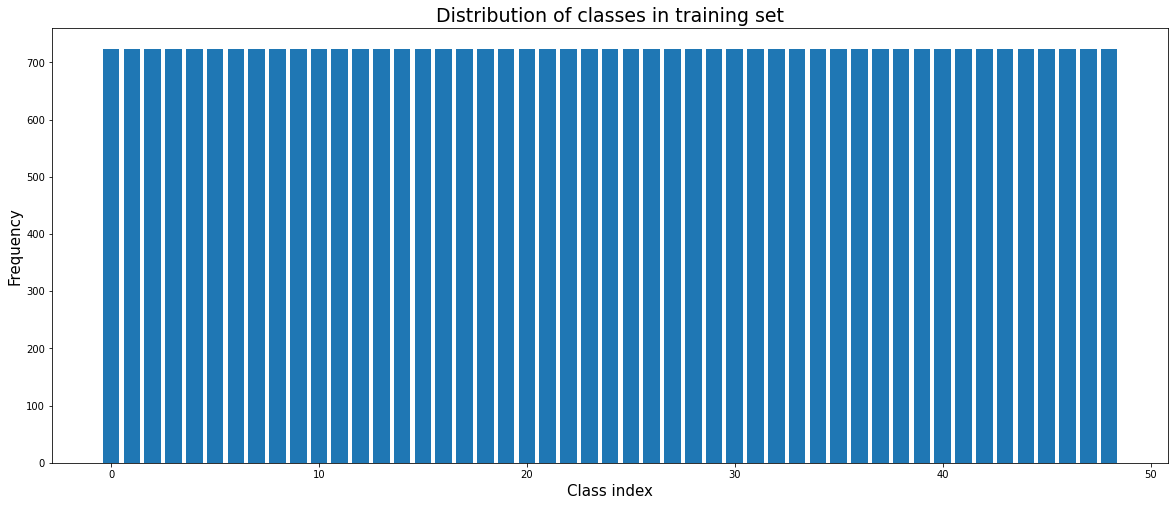

In [54]:
df_train_oversampled = oversample_dataframe(df_train)

plt.figure(figsize=(20, 8))
count_classes_train = df_train_oversampled[new_class_names].sum(axis=0).values
bins = np.arange(0, len(new_class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

That looks good. Now we have a fully balanced dataframe. Let's now create the training loop for comparing the fully balanced to the imbalanced training. <br> 
We only have to train the oversampling case, because we can reuse the results from the network with our new target image size as the results for the imbalanced learning.

In [59]:
target_image_size = (32, 32)
img_height, img_width = target_image_size
num_epochs = 1
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
depth = 3 # using rgb
oversampling_results = list()

# setup input pipeline
datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train_oversampled, directory=path_to_images,
                                                    x_col="filename", y_col=df_train_oversampled.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(new_class_names), 
                                              input_shape=(img_height, img_width, depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

initial_learning_rate = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# define the metrics
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(),
    keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

# fit the model for num_epochs epochs
hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)

# get the maximum validation f1-score and validation accuracy and store them
oversampling_results = [np.max(hist_dict.history["val_f1_score"]), 
                        np.max(hist_dict.history["val_categorical_accuracy"])]

Found 1000 validated image filenames.
Found 1629 validated image filenames.
125/125 [==============================] - 94s 647ms/step - loss: 0.8934 - categorical_accuracy: 0.6800 - auc: 0.9800 - f1_score: 0.6518 - val_loss: 15.7267 - val_categorical_accuracy: 0.0203 - val_auc: 0.4928 - val_f1_score: 0.0015


Now let's come to the last evaluation step: Searching good hyperparameters using Bayesian Hyperparameter search.

In [61]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from skopt.callbacks import CheckpointSaver

In [62]:
# create hyperparameter search space

dim_learning_rate = Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate')
dim_batch_size = Categorical([8, 16], name='batch_size')
dim_optimizer = Categorical(categories=["Adam", "RMSProp"], name="optimizer")
dim_decay = Real(low=0.95, high=1, name="decay_rate")
dim_steps_multiplier = Real(low=1, high=3, name="decay_steps")

dimensions = [dim_learning_rate,
              dim_batch_size,
              dim_optimizer,
              dim_decay,
              dim_steps_multiplier]

default_parameters = [[1e-5, 16, "Adam", 1, 3],
                      [1e-3, 16, "Adam", 0.95, 3],
                      [1e-5, 16, "RMSProp", 1, 3],
                      [1e-3, 16, "RMSProp", 0.95, 3]
                     ]

In [70]:
# let's write a create model function to easily return the keras model with all required parameters and setup

def create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train, encoder, new_class_names):
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(new_class_names), 
                                                  input_shape=(32, 32, 3),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps= int(decay_steps * steps_per_epoch_train),
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
        
    if optimizer == "RMSProp":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule,
                                                       rho=0.9, momentum=0.9, name="RMSprop")
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name="Adam")
        
    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics_list)
    
    return model

In [73]:
# let's now create the fitness function that shall be optimized

def create_fitness_func(encoder, new_class_names):

    @use_named_args(dimensions=dimensions)
    def fitness(learning_rate, batch_size, optimizer, decay_rate, decay_steps):

        # create data generators in order to load the images
        datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
        datagen_val = ImageDataGenerator(rescale = 1. / 255)

        train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                            x_col="filename", y_col=df_train.columns[3:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                            x_col="filename", y_col=df_val.columns[3:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        # set parameters for learning
        steps_per_epoch_train = train_generator.__len__()
        steps_per_epoch_val = valid_generator.__len__()
        print(f"Steps per training epoch: {steps_per_epoch_train}")
        print(f"Steps per validation epoch: {steps_per_epoch_val}")

        # create model
        model = create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train,
                             encoder, new_class_names)

        history = model.fit(train_generator, epochs=1, verbose=1, validation_data=valid_generator)

        f1_score = np.amax(history.history["val_f1_score"])

        if np.isnan(f1_score):
            f1_score = -1.0

        print(f"\nBest Validation F1-Score: {f1_score}\n")

        # dump results to json file
        dict_results = {}
        dict_results["learning_rate"] = learning_rate
        dict_results["batch_size"] = int(batch_size)
        dict_results["optimizer"] = optimizer
        dict_results["decay_rate"] = decay_rate
        dict_results["decay_steps"] = decay_steps
        dict_results["best_val_f1_score"] = f1_score

        # delete model from memory
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
        tf.compat.v1.reset_default_graph()

        # the optimizer aims for the lowest score, so return negative f1_score
        return -f1_score
    return fitness

In [75]:
encoder = "densenet121"

gp_result = gp_minimize(func=create_fitness_func(encoder, new_class_names),
                        dimensions=dimensions,
                        n_calls=12,
                        n_jobs=-1,
                        acq_func="LCB",
                        kappa = 10,
                        n_initial_points=4,
                        x0=default_parameters,
                        verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
Found 6515 validated image filenames.
Found 1629 validated image filenames.
Steps per training epoch: 408
Steps per validation epoch: 102
408/408 [==============================] - 245s 565ms/step - loss: 4.5564 - categorical_accuracy: 0.0259 - auc: 0.5461 - f1_score: 0.0000e+00 - val_loss: 4.2930 - val_categorical_accuracy: 0.0350 - val_auc: 0.5759 - val_f1_score: 0.0012

Best Validation F1-Score: 0.0011916370131075382



UnboundLocalError: local variable 'iteration' referenced before assignment

In [ ]:
# Next Steps: 
# 1. Check data distribution
# 2. Create tensorflow input pipeline with normalization, conversion to grayscale
# 3. Use small images to find best suited cnn
# 4. Apply data augmentation.
# 5. Check different images sizes on winning cnn.
# 6. Check oversampling vs. imblanced. 
# 7. Apply Bayesian Hyperparameter Search to find best hyperparameters.
# 8. Train final model.
# 9. Plot Class Activation Maps.